In [14]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.convolution



In [15]:
x_start = 1700
x_end = 1900

y_start = 1500
y_end = 1700

data = fits.getdata('D00387788_r_c24_r3567p02_immasked.fits')[x_start:x_end, y_start:y_end]


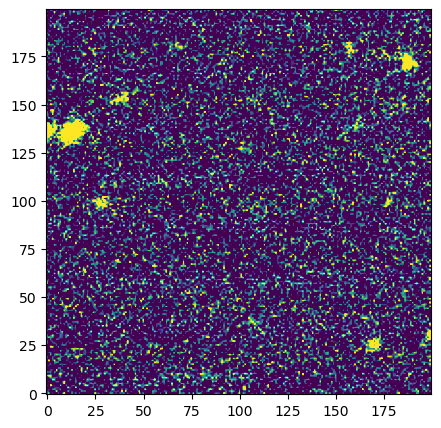

In [16]:
plt.figure(figsize=(5,5))
vmin, vmax = np.percentile(data, [55, 95])
plt.imshow(data, vmin = vmin, vmax = vmax, origin='lower')

In [91]:
def find_peaks(image, threshold):
    peak_x_values = []
    peak_y_values = []
    for j in range(np.shape(image)[1]):  # x
        for i in range(np.shape(image)[0]):  # y
            try:
                if image[i, j] > threshold:
                    point = image[i, j]
                    north = image[i-1, j]
                    south = image[i+1, j]
                    east = image[i, j+1]
                    west = image[i, j-1]
                    ne = image[i-1, j+1]
                    nw = image[i-1, j-1]
                    se = image[i+1, j+1]
                    sw = image[i+1, j-1]
                    max_ = np.argmax(np.array([point, np.mean([north, south, east, west, ne, nw, se, sw])]))
                    if max_ == 0:
                        peak_x_values.append(j)
                        peak_y_values.append(i)
            except IndexError:
                pass  # skip edges
    return np.array(peak_x_values), np.array(peak_y_values)

In [109]:
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel
# Answer
gauss = Gaussian2DKernel(x_stddev=2.6)

convolved_image = convolve(data, gauss)

peak_x_values, peak_y_values = find_peaks(data, threshold = 120)

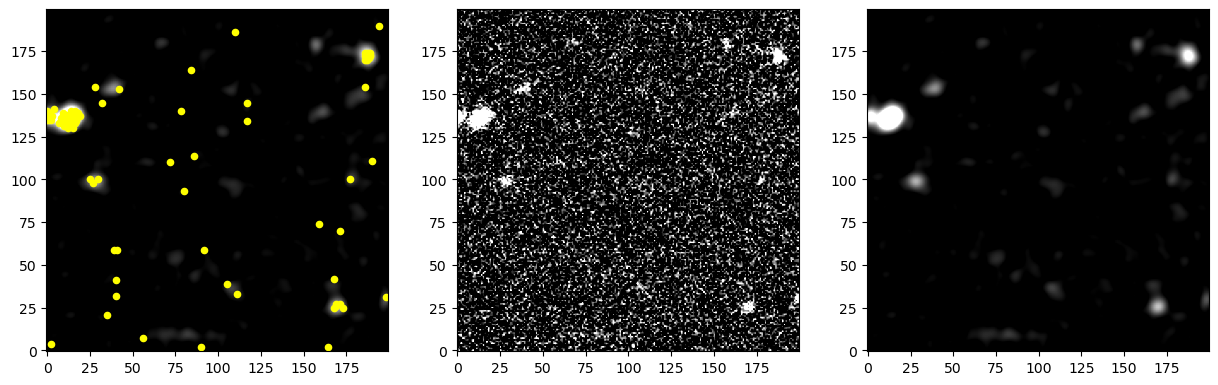

In [110]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
vmin, vmax = np.percentile(data, [55, 95])
plt.imshow(convolved_image, vmin = vmin, vmax = vmax, cmap='gray', origin='lower')
plt.scatter(peak_x_values, peak_y_values, s = 20, color = 'yellow')

plt.subplot(1,3,2)
plt.imshow(data, vmin = vmin, vmax = vmax, cmap='gray', origin='lower')

plt.subplot(1,3,3)
plt.imshow(convolved_image, vmin = vmin, vmax = vmax, cmap='gray', origin='lower')

In [59]:
np.min(convolved_image)

-16.497131